In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#Part 4a

In [4]:
#simulate_ar1 - gnerate ground truth data
def simulate_ar1(T,a=0.4,sigma_v=1.0,sigma_e=1.0,x0=0.0,rng=None):
    if rng is None:
        rng=np.random.default_rng()
    x=np.zeros(T); y=np.zeros(T); x[0]=x0
    for t in range(T):
        y[t]=x[t]+rng.normal(0.0,sigma_e)
        if t<T-1:
            x[t+1]=a*x[t]+rng.normal(0.0,sigma_v)
    return x,y


In [5]:
#ekf implementation with parameter in state vector
def ekf_param_in_state(y,a_init=0.5,P0=None,sigma_v=1.0,sigma_e=1.0,q_a=1e-6):
    if P0 is None:
        P0=np.diag([1.0,1.0])
    T=len(y)
    z=np.array([0.0,a_init],dtype=float)
    P=P0.copy()
    Q=np.diag([sigma_v**2,q_a])
    R=np.array([[sigma_e**2]])
    H=np.array([[1.0,0.0]])
    I=np.eye(2)
    Z=np.zeros((T,2))
    Pseq=np.zeros((T,2,2))
    for t in range(T):
        #measupdate
        y_pred=z[0]
        innov=y[t]-y_pred
        S=H@P@H.T+R
        K=(P@H.T)/S
        z=z+(K.flatten()*innov)
        P=(I-K@H)@P
        Z[t]=z; Pseq[t]=P
        #timeupdate
        if t<T-1:
            x,a=z
            z=np.array([a*x,a],dtype=float)
            F=np.array([[a,x],[0.0,1.0]])
            P=F@P@F.T+Q
    return Z,Pseq


In [6]:
#the function for running  the EKF experiment 20 times
def run_ekf_sims(n_runs=20,T=200,a_true=0.4,sigma_v=1.0,sigma_e=1.0,seed=123):
    rng=np.random.default_rng(seed)
    final_a=[]; rmse_x=[]; a_traj=np.zeros((n_runs,T))
    for r in range(n_runs):
        x_true,y=simulate_ar1(T,a=a_true,sigma_v=sigma_v,sigma_e=sigma_e,rng=rng)
        Z,_=ekf_param_in_state(y,a_init=0.6,P0=np.diag([1.0,1.0]),sigma_v=sigma_v,sigma_e=sigma_e,q_a=1e-6)
        x_hat=Z[:,0]; a_hat=Z[:,1]
        final_a.append(a_hat[-1]); a_traj[r]=a_hat
        rmse_x.append(np.sqrt(np.mean((x_true-x_hat)**2)))
    return np.array(final_a),np.array(rmse_x),a_traj


In [7]:
#single-run-demo, run the EKF once and check if it behaves correctly
T=200
x_true,y=simulate_ar1(T,a=0.4,sigma_v=1.0,sigma_e=1.0,rng=np.random.default_rng(1))
Z,Pseq=ekf_param_in_state(y,a_init=0.6,P0=np.diag([1.0,1.0]),sigma_v=1.0,sigma_e=1.0,q_a=1e-6)
x_hat=Z[:,0]; a_hat=Z[:,1]; t=np.arange(T)


Final a-hat per run:
 [0.3375 0.5499 0.3688 0.2728 0.6072 0.3259 0.4454 0.4441 0.349  0.3359
 0.3808 0.3317 0.227  0.5574 0.5537 0.5016 0.3    0.5549 0.3895 0.4824]

State RMSE per run:
 [0.7153 0.7327 0.7047 0.7748 0.7559 0.7278 0.7096 0.6969 0.7284 0.7531
 0.7232 0.7058 0.716  0.7211 0.6722 0.7553 0.7293 0.7163 0.7592 0.7252]

Summary:
 {'mean_final_a_hat': 0.4157795563017156, 'std_final_a_hat': 0.11056308211271422, 'mean_state_RMSE': 0.7261468857383296, 'std_state_RMSE': 0.02433261106118903}


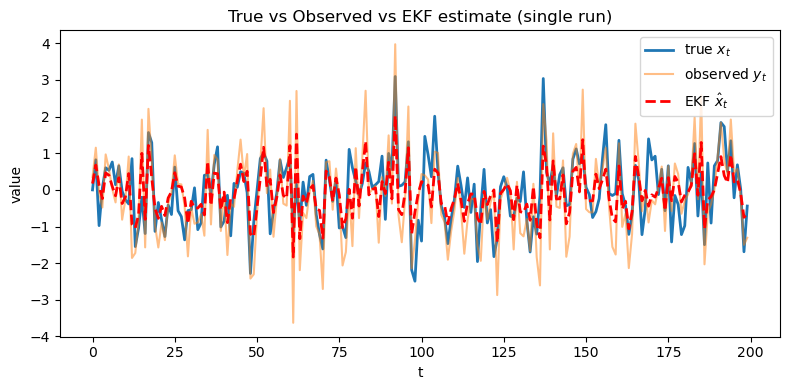

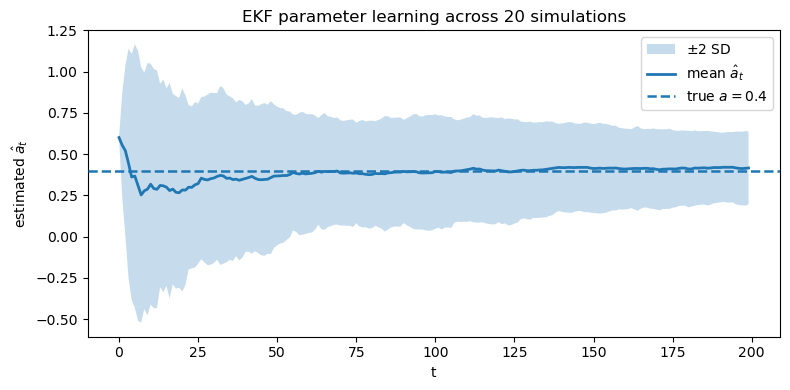

In [8]:
#executing 20 simulations without knowing the value of a to estimate the mean final a(t)
final_a_hats,rmse_x,a_traj=run_ekf_sims(n_runs=20,T=T,a_true=0.4,sigma_v=1.0,sigma_e=1.0,seed=123)
print("Final a-hat per run:\n",np.round(final_a_hats,4))
print("\nState RMSE per run:\n",np.round(rmse_x,4))
print("\nSummary:\n",{
    "mean_final_a_hat":float(final_a_hats.mean()),
    "std_final_a_hat":float(final_a_hats.std(ddof=1)),
    "mean_state_RMSE":float(rmse_x.mean()),
    "std_state_RMSE":float(rmse_x.std(ddof=1))
})

#Visualize how the EKF reconstructs the hidden state x(t) from noisy data y(t)
plt.figure(figsize=(8,4))
plt.plot(t,x_true,label=r"true $x_t$",linewidth=2)
plt.plot(t,y,label=r"observed $y_t$",alpha=0.5)
plt.plot(t,x_hat,label=r"EKF $\hat{x}_t$",linewidth=2,linestyle="--", color="red")
plt.title("True vs Observed vs EKF estimate (single run)")
plt.xlabel("t"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()


#shows how the parameter a is learned over time
mean_a=a_traj.mean(axis=0); std_a=a_traj.std(axis=0,ddof=1)
plt.figure(figsize=(8,4))
plt.fill_between(t,mean_a-2*std_a,mean_a+2*std_a,alpha=0.25,label=r"$\pm2$ SD")
plt.plot(t,mean_a,label=r"mean $\hat{a}_t$",linewidth=2)
plt.axhline(0.4,linestyle="--",linewidth=1.8,zorder=10,label=r"true $a=0.4$")
plt.title("EKF parameter learning across 20 simulations")
plt.xlabel("t"); plt.ylabel(r"estimated $\hat{a}_t$"); plt.legend(); plt.tight_layout(); plt.show()



In [9]:
#Part 4b

C:\Users\snehi\AppData\Local\Temp\ipykernel_32396\1003259754.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H.T @ P @ H + Re)                           # innovation var (scalar)


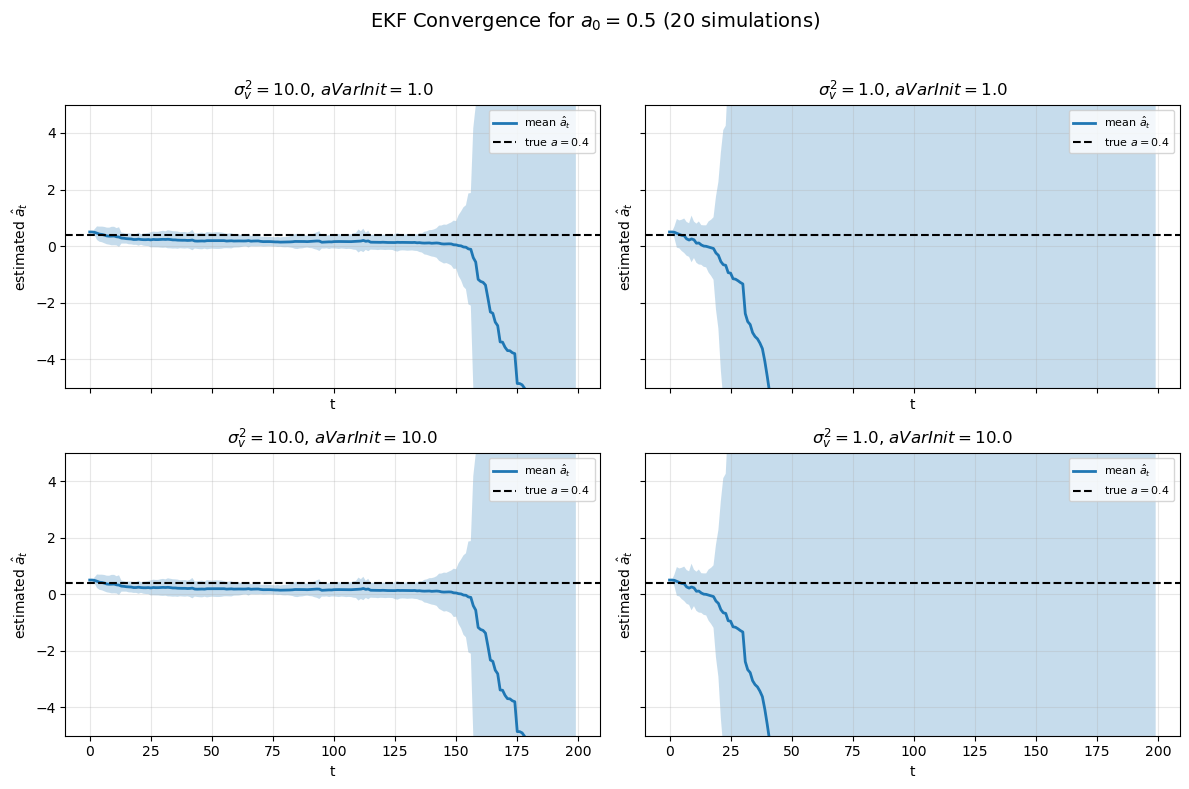

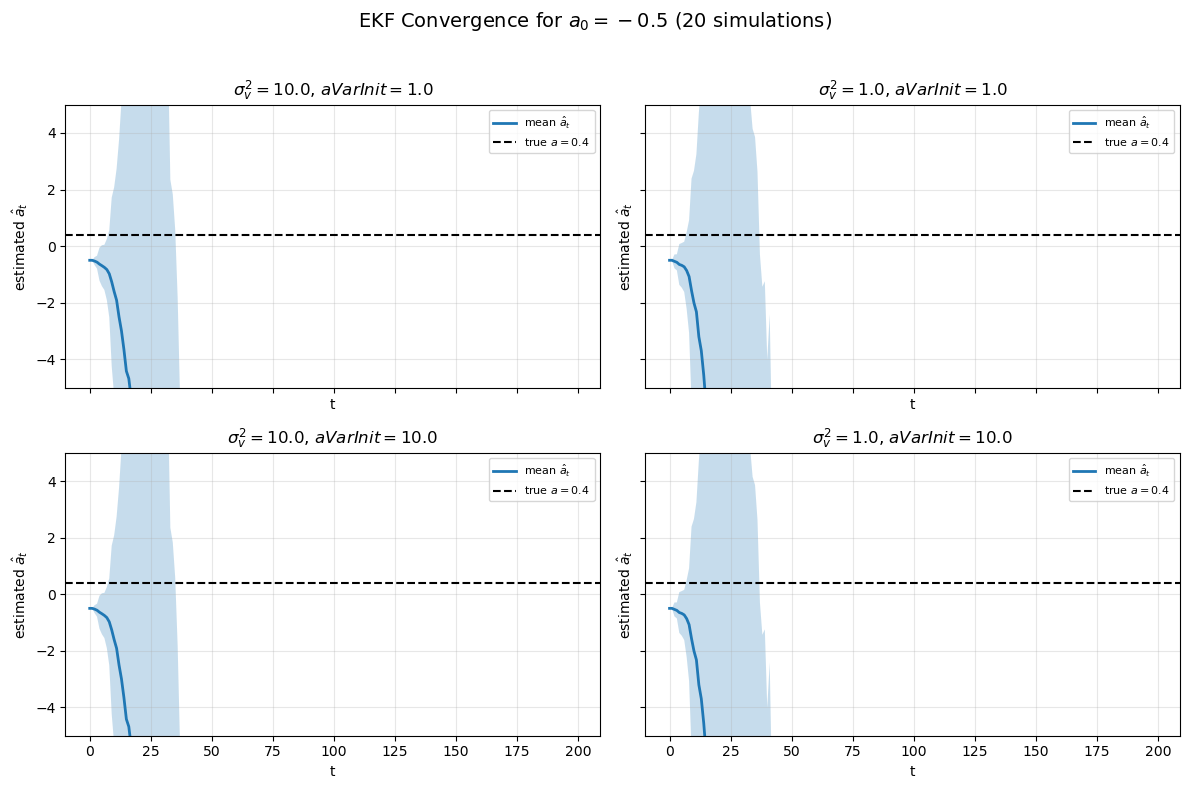

In [10]:
#here teh 'a' can only change via Kalman gain corrections, no process noise for 'a'
import numpy as np
import matplotlib.pyplot as plt

#simulate_ar1: x_{t+1}=a*x_t+v_t, y_t=x_t+e_t
def simulate_ar1(T,a=0.4,sigma_v=1.0,sigma_e=1.0,x0=0.0,rng=None):
    if rng is None:
        rng=np.random.default_rng()
    x=np.zeros(T); y=np.zeros(T); x[0]=x0
    for t in range(T):
        y[t]=x[t]+rng.normal(0.0,sigma_e)
        if t<T-1:
            x[t+1]=a*x[t]+rng.normal(0.0,sigma_v)
    return x,y

def ekf_r_style(y, aInit=0.5, aVarInit=1.0, sigma_v=1.0, sigma_e=1.0):
    #EKF for z=[x,a], R-to-Python with correct time alignment (predict to t, update with y[t])
    T = len(y)
    z = np.array([0.0, aInit], dtype=float)                   # [x0, a0]
    Rv = np.array([[sigma_v**2, 0.0], [0.0, 0.0]])            # process noise only on x
    Re = sigma_e**2                                           # measurement noise variance
    P  = np.array([[Re, 0.0], [0.0, aVarInit]])               # initial covariance (as in R)
    H  = np.array([[1.0], [0.0]])                             # column vector
    Z  = np.zeros((T, 2)); Z[0] = z
    aVar = np.full(T, np.nan)

    #loop t=1..T-1: predict to time t, then update with y[t], store at Z[t]
    for t in range(1, T):
        F = np.array([[z[1], 0.0], [z[0], 1.0]])              # Jacobian at time t-1
        z = np.array([z[1] * z[0], z[1]], dtype=float)        # predict z_{t|t-1}
        P = F @ P @ F.T + Rv                                  # predict P_{t|t-1}

        res = y[t] - z[0]                                     # innovation with y_t
        S = float(H.T @ P @ H + Re)                           # innovation var (scalar)
        K = (P @ H) / S                                       # Kalman gain (2x1)

        z = z + K.flatten() * res                             # update z_{t|t}
        P = (np.eye(2) - K @ H.T) @ P                         # update P_{t|t}

        Z[t] = z
        aVar[t] = P[1, 1]

    return Z, aVar


#run_many: repeat EKF for multiple noise realizations
def run_many(n_runs=20,T=200,a_true=0.4,truth_sig_v=1.0,truth_sig_e=1.0,
             aInit=0.5,aVarInit=1.0,filter_sig_v=1.0,filter_sig_e=1.0,seed=123):
    rng=np.random.default_rng(seed)
    a_paths=np.zeros((n_runs,T))
    for r in range(n_runs):
        _,y=simulate_ar1(T,a=a_true,sigma_v=truth_sig_v,sigma_e=truth_sig_e,rng=rng)
        Z,_=ekf_r_style(y,aInit=aInit,aVarInit=aVarInit,
                        sigma_v=filter_sig_v,sigma_e=filter_sig_e)
        a_paths[r]=Z[:,1]
    return a_paths

#plot_all_combinations: create 4 subplots for a single initial a0
def plot_all_combinations(a0,combos,n_runs=20,T=200):
    fig,axes=plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
    axes=axes.ravel()
    for i,(sigv2,aVarInit) in enumerate(combos):
        a_paths=run_many(n_runs=n_runs,T=T,a_true=0.4,
                         truth_sig_v=1.0,truth_sig_e=1.0,
                         aInit=a0,aVarInit=aVarInit,
                         filter_sig_v=np.sqrt(sigv2),filter_sig_e=1.0,seed=123)
        mean_a=a_paths.mean(axis=0)
        std_a=a_paths.std(axis=0,ddof=1)
        t=np.arange(T)
        ax=axes[i]
        ax.fill_between(t,mean_a-2*std_a,mean_a+2*std_a,alpha=0.25)
        ax.plot(t,mean_a,label=r"mean $\hat{a}_t$",linewidth=2)
        ax.axhline(0.4,linestyle="--",linewidth=1.5,color="black",label=r"true $a=0.4$")
        ax.set_title(fr"$\sigma_v^2={sigv2}$, $aVarInit={aVarInit}$")
        ax.grid(True,alpha=0.3)
    fig.suptitle(fr"EKF Convergence for $a_0={a0}$ (20 simulations)",fontsize=14)
    for ax in axes:
        ax.set_xlabel("t")
        ax.set_ylabel(r"estimated $\hat{a}_t$")
        ax.legend(fontsize=8)
        ax.set_ylim(-5, 5)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

#=== Run and plot ===
T=200; n_runs=20
combos=[(10.0,1.0),(1.0,1.0),(10.0,10.0),(1.0,10.0)]

plot_all_combinations(a0=0.5,combos=combos,n_runs=n_runs,T=T)
plot_all_combinations(a0=-0.5,combos=combos,n_runs=n_runs,T=T)


C:\Users\snehi\AppData\Local\Temp\ipykernel_32396\3785464633.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(H @ P @ H.T + R)
C:\Users\snehi\AppData\Local\Temp\ipykernel_32396\3785464633.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = z + K0.flatten() * float(r0)
C:\Users\snehi\AppData\Local\Temp\ipykernel_32396\3785464633.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = y[t+1] - float(H @ z_pred)
C:\Users\snehi\AppData\Local\Temp\i

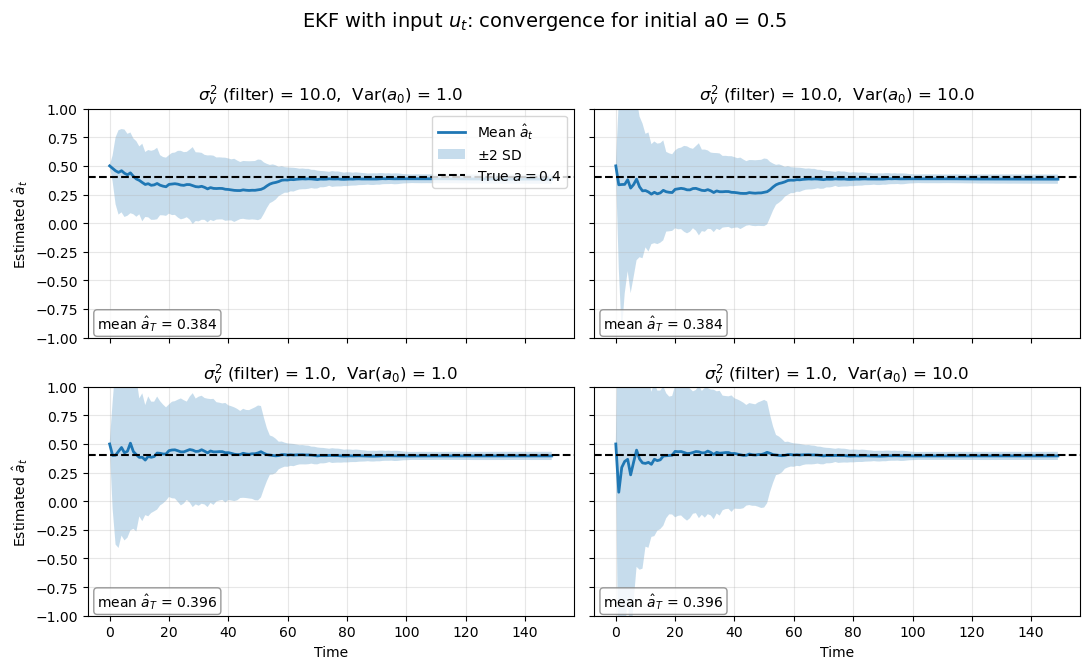

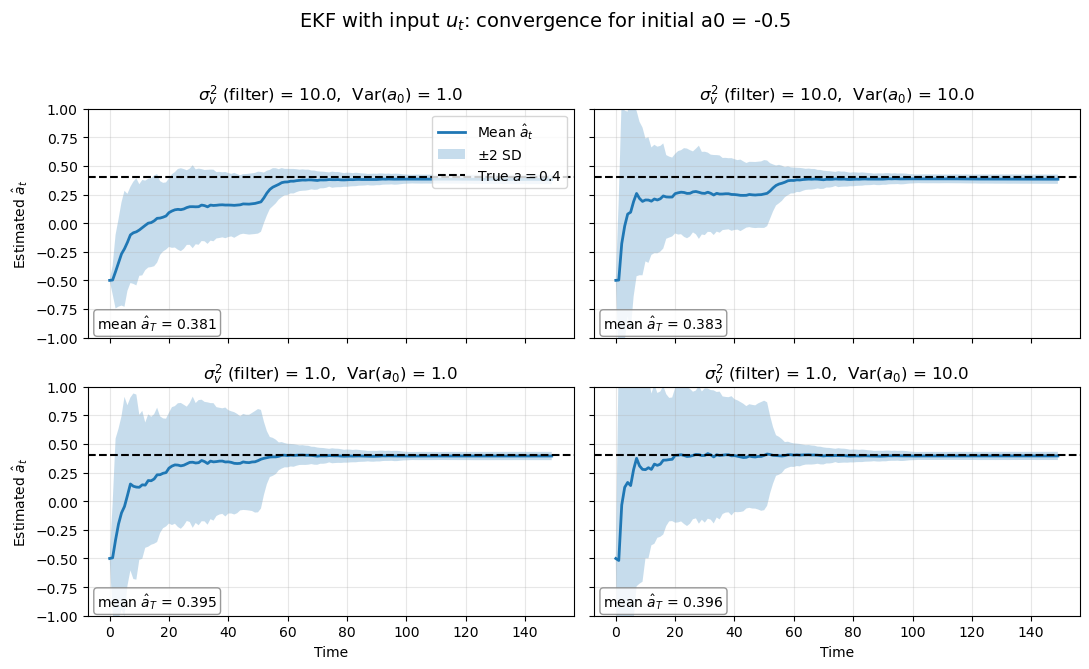

In [ ]:
#now we are adding an external input u_t to the system, which affects the state x_t directly
#this should make the system more observable and help estimate 'a' better - and more stable too (hopefully)
#true system params
A_TRUE = 0.4
SIGMA_V_TRUE = 1.0
SIGMA_E_TRUE = 1.0

#u_t generator: two steps (0 -> 5 -> 0) by default
def make_u(N, u1=0.0, u2=5.0, u3=0.0):
    u = np.zeros(N)
    t1 = N//3
    t2 = 2*N//3
    u[:t1] = u1
    u[t1:t2] = u2
    u[t2:] = u3
    return u

def simulate_xy_u(N, u, a_true=A_TRUE, sigma_v=SIGMA_V_TRUE, sigma_e=SIGMA_E_TRUE, seed=None):
    rng = np.random.default_rng(seed)
    v = rng.normal(0.0, sigma_v, size=N)
    e = rng.normal(0.0, sigma_e, size=N)
    x = np.zeros(N)
    for t in range(N-1):
        x[t+1] = a_true * x[t] + u[t] + v[t]
    y = x + e
    return x, y

#EKF with unknown a and known input u_t; state z=[x,a]
#time: initial update at t=0, then predict to t+1 with u[t], update with y[t+1]
def ekf_unknown_a_with_u(y, u,
                         sigma_v_filter=1.0,
                         sigma_e_filter=1.0,
                         sigma_w=1e-3,
                         a_init=0.5,
                         P_x0=1.0,
                         P_a0=1.0):
    N = len(y)
    z = np.array([0.0, a_init], dtype=float)
    P = np.diag([P_x0, P_a0]).astype(float)
    Q = np.diag([sigma_v_filter**2, sigma_w**2])
    R = sigma_e_filter**2
    H = np.array([[1.0, 0.0]])
    I = np.eye(2)

    Z = np.zeros((N,2))
    Pseq = np.zeros((N,2,2))

    #initial update with y[0]
    r0 = y[0] - (H @ z)
    S0 = float(H @ P @ H.T + R)
    K0 = (P @ H.T) / S0
    z = z + K0.flatten() * float(r0)
    P = (I - K0 @ H) @ P
    Z[0] = z
    Pseq[0] = P

    for t in range(N-1):
        x_t, a_t = z
        #predict to t+1 using u[t]
        z_pred = np.array([a_t * x_t + u[t], a_t], dtype=float)
        F = np.array([[a_t, x_t],
                      [0.0, 1.0]], dtype=float)  # df/dz, u_t is additive so d/du not in F
        P_pred = F @ P @ F.T + Q

        #update with y[t+1]
        r = y[t+1] - float(H @ z_pred)
        S = float(H @ P_pred @ H.T + R)
        K = (P_pred @ H.T) / S
        z = z_pred + K.flatten() * r

        #Joseph form (stable)
        KH = K @ H
        P = (I - KH) @ P_pred @ (I - KH).T + (K * R) @ K.T

        Z[t+1] = z
        Pseq[t+1] = P

    return Z, Pseq

#experiment: 4 configs × 2 initial a0 values, with input u_t
def run_experiment_with_u(N=100, n_sims=20,
                          a0_list=(0.5, -0.5),
                          sigma_v2_filter_list=(10.0, 1.0),
                          P_a0_list=(1.0, 10.0),
                          sigma_w=1e-3,
                          u_builder=lambda N: make_u(N, 0.0, 5.0, 0.0)):
    results = {}
    for a0 in a0_list:
        for sigma_v2 in sigma_v2_filter_list:
            for P_a0 in P_a0_list:
                A_traj = []
                for s in range(n_sims):
                    u = u_builder(N)
                    _, y = simulate_xy_u(N, u, a_true=A_TRUE,
                                         sigma_v=SIGMA_V_TRUE, sigma_e=SIGMA_E_TRUE, seed=s)
                    Z, _ = ekf_unknown_a_with_u(
                        y, u,
                        sigma_v_filter=np.sqrt(sigma_v2),
                        sigma_e_filter=SIGMA_E_TRUE,
                        sigma_w=sigma_w,
                        a_init=a0,
                        P_x0=1.0,
                        P_a0=P_a0
                    )
                    A_traj.append(Z[:,1])
                A_traj = np.stack(A_traj, axis=1)  # (N, n_sims)
                results[(a0, sigma_v2, P_a0)] = {
                    "a_mean": A_traj.mean(axis=1),
                    "a_std":  A_traj.std(axis=1, ddof=1),
                    "a_all":  A_traj
                }
    return results

#plot 2x2 grid for a fixed a0, with mean final a printed on each subplot
def plot_grid_with_u(results, a0, N=100, title_prefix="EKF with input u_t"):
    fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True, sharey=True)
    combos = [ (10.0, 1.0), (10.0, 10.0), (1.0, 1.0), (1.0, 10.0) ]
    positions = [ (0,0), (0,1), (1,0), (1,1) ]
    t = np.arange(N)

    for (sigma_v2, P_a0), (r, c) in zip(combos, positions):
        ax = axes[r, c]
        key = (a0, sigma_v2, P_a0)
        a_mean = results[key]["a_mean"]
        a_std  = results[key]["a_std"]

        ax.plot(t, a_mean, lw=2, label=r"Mean $\hat a_t$")
        ax.fill_between(t, a_mean - 2*a_std, a_mean + 2*a_std, alpha=0.25, label=r"$\pm 2$ SD")
        ax.axhline(A_TRUE, ls="--", color="k", label=r"True $a=0.4$")
        ax.set_title(rf"$\sigma_v^2$ (filter) = {sigma_v2},  Var$(a_0)$ = {P_a0}")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1, 1)

        #annotate mean final a_T on the plot
        aT = a_mean[-1]
        ax.text(0.02, 0.04, rf"mean $\hat a_T$ = {aT:.3f}",
                transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.5", alpha=0.8))

    axes[0,0].legend(loc="upper right")
    for ax in axes[-1,:]:
        ax.set_xlabel("Time")
    for ax in axes[:,0]:
        ax.set_ylabel(r"Estimated $\hat a_t$")

    fig.suptitle(f"{title_prefix}: convergence for initial a0 = {a0}", fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#==== run everything ====
if __name__ == "__main__":
    N = 150
    n_sims = 20
    sigma_w = 1e-3  # try 1e-4 or 0.0 to compare

    results = run_experiment_with_u(
        N=N,
        n_sims=n_sims,
        a0_list=(0.5, -0.5),
        sigma_v2_filter_list=(10.0, 1.0),
        P_a0_list=(1.0, 10.0),
        sigma_w=sigma_w,
        u_builder=lambda N: make_u(N, 0.0, 5.0, 0.0)  # two-step input
    )

    plot_grid_with_u(results, a0=0.5, N=N, title_prefix="EKF with input $u_t$")
    plot_grid_with_u(results, a0=-0.5, N=N, title_prefix="EKF with input $u_t$")
